In [1]:
import torch
from transformers import CLIPTokenizer

/home/mlfavorfit/anaconda3/envs/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

## Device Check

In [3]:
DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

Using device: cuda


## Load CLIP Tokenizer

In [4]:
tokenizer = CLIPTokenizer("./data/vocab.json", merges_file="./data/merges.txt")

## Useful function

In [5]:
from PIL import Image
import random

In [6]:
def convert_to_random_color_tiles(colors, weights, image_size=[512,512], tile_num_per_row=4):
    # 이미지 열기
    img = Image.new('RGB', image_size)

    # 이미지 크기 가져오기
    width, height = img.size
    tile_size = (512//tile_num_per_row, 512//tile_num_per_row)

    # 타일별로 이미지를 자르고 랜덤한 색상의 타일로 대체
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # 랜덤하게 색상 섞기
            seleted_color = random.choices(colors, weights, k=1)[0]

            # 랜덤한 타일 생성
            tile = Image.new('RGB', tile_size, seleted_color)

            # 원본 이미지에 랜덤한 타일 적용
            img.paste(tile, (x, y, x + tile_size[0], y + tile_size[1]))

    # 결과 이미지 저장 또는 표시
    # img.show()
    return img

In [7]:
def center_crop_and_resize(input_path, target_size=(512, 512)):
    # 이미지 열기
    image = Image.open(input_path)

    # 이미지의 중앙을 기준으로 자르기
    width, height = image.size
    left = (width - min(width, height)) // 2
    top = (height - min(width, height)) // 2
    right = (width + min(width, height)) // 2
    bottom = (height + min(width, height)) // 2
    image = image.crop((left, top, right, bottom))

    # 리사이징
    image = image.resize(target_size, Image.ANTIALIAS)

    # 결과 저장
    return image

In [8]:
import numpy as np
def composing_output(generated_img, mask, original_img):
    generated_img = np.array(generated_img)
    mask = np.array(mask)
    original_img = np.array(original_img)
    
    composed_output = np.array(generated_img) * (1-mask/255) + np.array(original_img) * (mask/255)
    return Image.fromarray(composed_output.astype(np.uint8))

In [9]:
import cv2
def make_canny_condition(image, min=100, max=200):
    image = np.array(image)
    image = cv2.Canny(image, min, max)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    image = Image.fromarray(image)
    return image

In [10]:
from postprocess_remove_bg.rmbg_postprocess import MaskPostProcessor
mask_post_processor = MaskPostProcessor()

## Outpaint
---

In [11]:
diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_base.pth")
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/outpaint_v2.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")

diffusion_state_dict["lora"] = lora_state_dict

In [12]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_lora":True}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict)

models.update(controlnet)

/tmp/ipykernel_31485/3280795657.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)


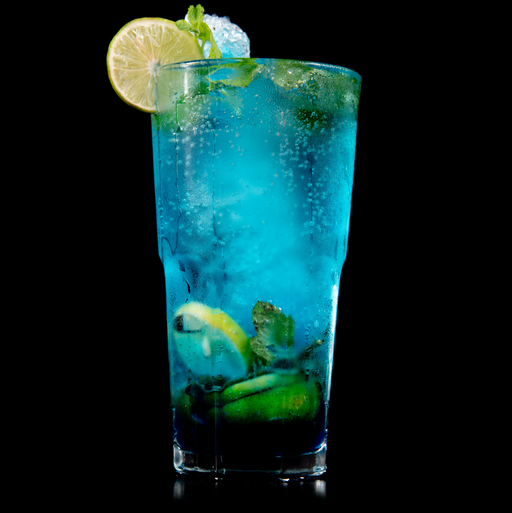

In [13]:
control_image = center_crop_and_resize("./images/demo_image/cocktail.jpg", target_size=[512,513])
mask_image = center_crop_and_resize("./images/demo_image/cocktail_mask.jpg", target_size=[512,513])
control_image

In [14]:
from Favorfit_remove_bg.inference import call_model, inference as mask_inference

remove_bg_model = call_model("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
mask_image = mask_inference(control_image, remove_bg_model)

2024-02-06 13:33:48.575793: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 13:33:48.576742: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 13:33:48.591665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 13:33:48.912572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mlfavorfit/anaconda3/envs/diffusion/lib/python3.8/site-packages/torch/functional.py:504: UserWar

In [15]:
from Favorfit_image_to_text.blip_image_to_text import load_interrogator, inference
interrogator = load_interrogator(model_path="/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/image_to_text/blip/blip_large.pth", device="cuda")
caption = inference(control_image, interrogator)
caption

'an iced beverage in a glass with ice, lime and lime'

In [16]:
from pipelines.pipline_default_controlnet import generate

output_images = generate(
    prompt=f"professional photography, natural shadow, {caption}, realistic, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=None,
    control_image=control_image,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=1.0,
    models=models,
    seeds=[42],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=0.7
)

100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


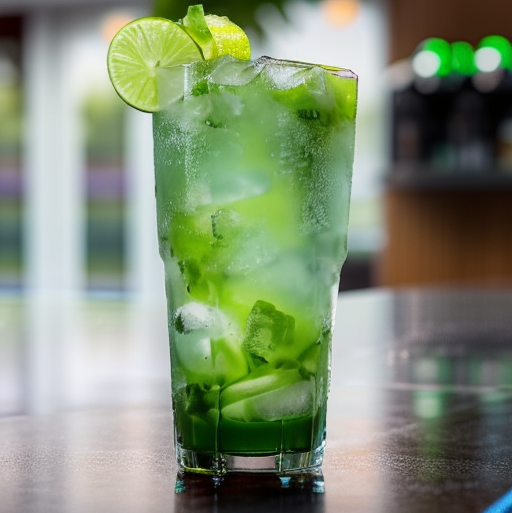

In [17]:
result_img = output_images[0]
result_img

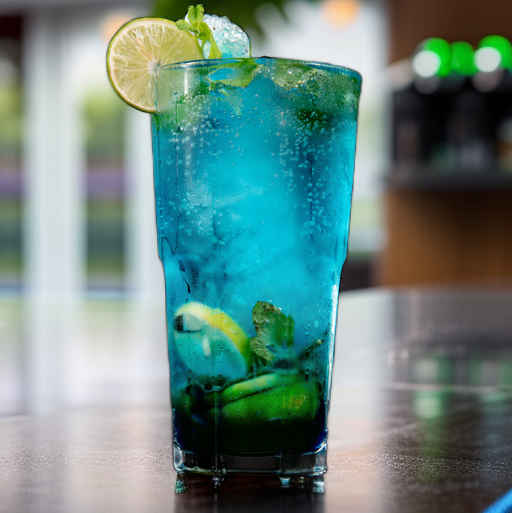

In [18]:
composed_img = composing_output(result_img, mask_image, control_image)
composed_img

## Composition

In [19]:
diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_inpaint.pth")
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/canny.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")


diffusion_state_dict["lora"] = lora_state_dict

In [20]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_inpaint":True, "is_lora":True}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict)

models.update(controlnet)

/tmp/ipykernel_31485/3280795657.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)


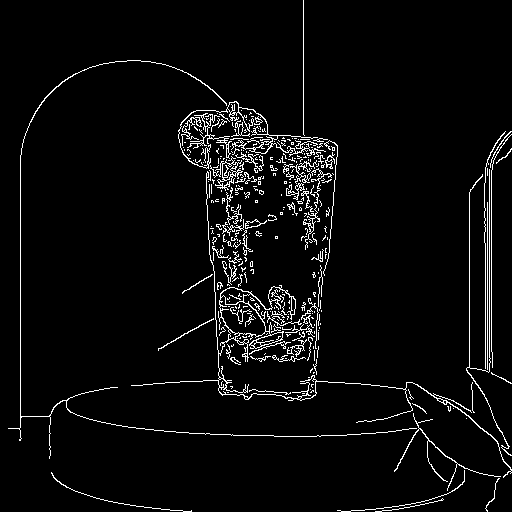

In [21]:
image = center_crop_and_resize("./images/demo_image/cocktail_template.png").convert("RGB")
control_image= make_canny_condition(image)
control_image

In [22]:
from Favorfit_remove_bg.inference import call_model, inference as mask_inference

remove_bg_model = call_model("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
mask = mask_inference(image, remove_bg_model)
reversed_mask = Image.fromarray(255 - np.array(mask.convert("L")))

In [23]:
from Favorfit_image_to_text.blip_image_to_text import load_interrogator, inference
interrogator = load_interrogator(model_path="/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/image_to_text/blip/blip_large.pth", device="cuda")
caption = inference(image, interrogator)
caption

'a tall glass filled with something blue and green'

In [24]:
from pipelines.pipeline_inpainting_controlnet import generate

output_images = generate(
    prompt=f"professional photography, natural shadow, {caption}, realistic, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=image,
    mask_image=reversed_mask,
    control_image=control_image,
    num_per_image=1,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=0.6,
    models=models,
    seeds=[42],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=0.7
)

100%|██████████| 12/12 [00:01<00:00,  6.56it/s]


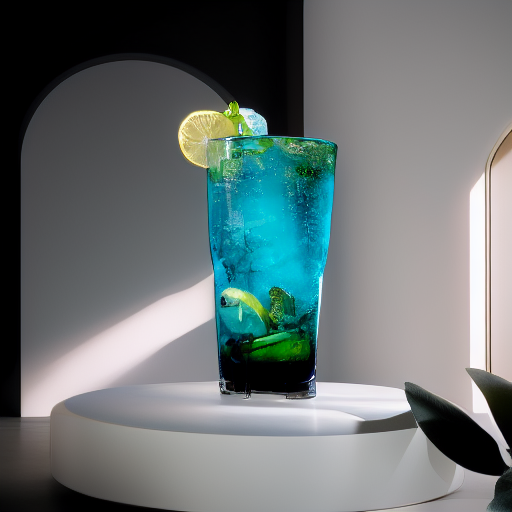

In [25]:
result_img = output_images[0]
result_img

## Augmentation

In [26]:
diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_base.pth")
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/shuffle.pth")
control_state_dict_2 = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/canny.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")


diffusion_state_dict["lora"] = lora_state_dict

In [27]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_lora":True}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model([control_state_dict, control_state_dict_2])

models.update(controlnet)

In [28]:
import cv2
def make_noise_disk(H, W, C, F):
    noise = np.random.uniform(low=0, high=1, size=((H // F) + 2, (W // F) + 2, C))
    noise = cv2.resize(noise, (W + 2 * F, H + 2 * F), interpolation=cv2.INTER_CUBIC)
    noise = noise[F: F + H, F: F + W]
    noise -= np.min(noise)
    noise /= np.max(noise)
    if C == 1:
        noise = noise[:, :, None]
    return noise

class ContentShuffleDetector:
    def __call__(self, img, h=None, w=None, f=None):
        H, W, C = img.shape
        if h is None:
            h = H
        if w is None:
            w = W
        if f is None:
            f = 256
        x = make_noise_disk(h, w, 1, f) * float(W - 1)
        y = make_noise_disk(h, w, 1, f) * float(H - 1)
        flow = np.concatenate([x, y], axis=2).astype(np.float32)
        return cv2.remap(img, flow, None, cv2.INTER_LINEAR)

In [29]:
csd = ContentShuffleDetector()

/tmp/ipykernel_31485/3280795657.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)


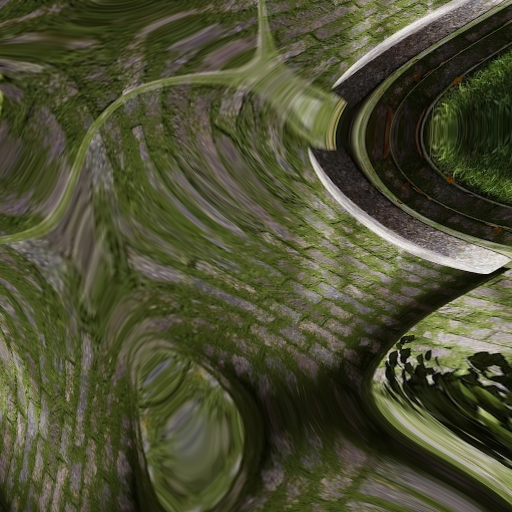

In [30]:
image = center_crop_and_resize("./images/test_image/template_base_2.jpg").convert("RGB")
style_image = center_crop_and_resize("./images/test_image/template_style.jpg").convert("RGB")
canny_image = make_canny_condition(image)
shuffle_image = Image.fromarray(csd(np.array(style_image)))
shuffle_image

In [31]:
from Favorfit_image_to_text.blip_image_to_text import load_interrogator, inference
interrogator = load_interrogator(model_path="/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/image_to_text/blip/blip_large.pth", device="cuda")
caption = inference(image, interrogator)
caption

'a wooden tray and two small plates'

In [32]:
from pipelines.pipline_default_controlnet import generate

output_images = generate(
    prompt=f"professional photography, natural shadow, {caption}, realistic, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=None,
    control_image=[shuffle_image, canny_image],
    num_per_image=1,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=0.99,
    models=models,
    seeds=[42],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=1.0,
    controlnet_scale=[1.0, 1.0]
)

100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


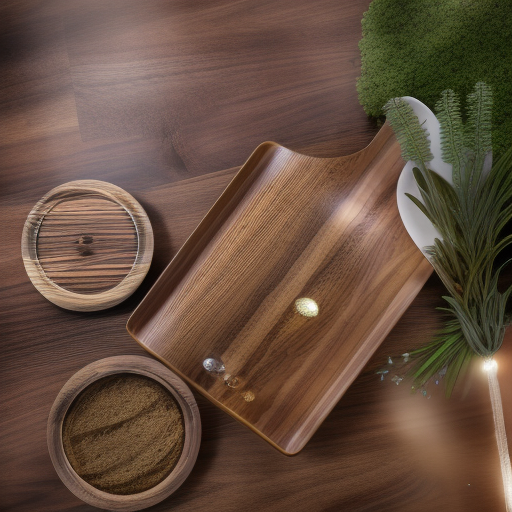

In [33]:
output_images[0]